#### Import libraries and load our data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, plot_roc_curve, roc_auc_score, 
accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score)
from imblearn.under_sampling import NearMiss

In [2]:
#Load datasets
train = pd.read_csv('../CapstoneTwo/train_final.csv')
test = pd.read_csv('../CapstoneTwo/test_final.csv')

#### Identify our dependent and independent variables

In [3]:
#Get X and y
X = train.drop(columns='WnvPresent')._get_numeric_data()
y = train['WnvPresent']

#### Split the data into train and test subsamples

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Scale data to prep for model creation

In [5]:
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

#### Undersample

In [6]:
nm = NearMiss(version=3)
X_train, y_train = nm.fit_resample(X_train, y_train)

# 1. Logistic Regression

#### Fit Logistic Regression Classifier

In [7]:
lr_clf = LogisticRegression(max_iter=100)
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)
y_pred_training = lr_clf.predict(X_train)
y_pred_probs = lr_clf.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_pred)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.6420637093829866

In [8]:
print("Classification Report for Training Data")
print(classification_report(y_train, y_pred_training))

Classification Report for Training Data
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       441
           1       0.68      0.68      0.68       441

    accuracy                           0.68       882
   macro avg       0.68      0.68      0.68       882
weighted avg       0.68      0.68      0.68       882



In [9]:
print("Classification Report for Test Data")
print(classification_report(y_test, y_pred))

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.97      0.70      0.81      1992
           1       0.10      0.58      0.17       110

    accuracy                           0.70      2102
   macro avg       0.53      0.64      0.49      2102
weighted avg       0.92      0.70      0.78      2102



#### Create Confusion Matrix Plots

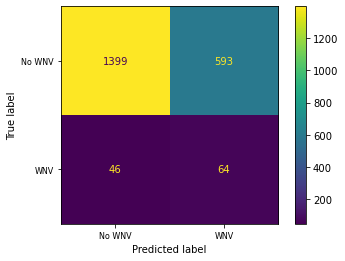

In [10]:
cm = confusion_matrix(y_test, y_pred, labels = lr_clf.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['No WNV', 'WNV'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['No WNV', 'WNV'], fontsize = 8)
ax.set_yticklabels(labels = ['No WNV', 'WNV'], fontsize = 8)
display_cm.plot(ax = ax)

#### Plot ROC

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.


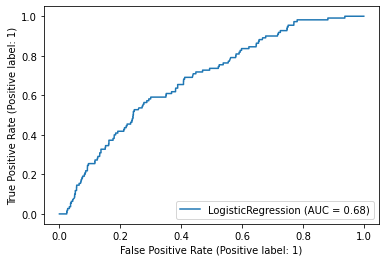

In [11]:
plot_roc_curve(lr_clf, X_test, y_test)

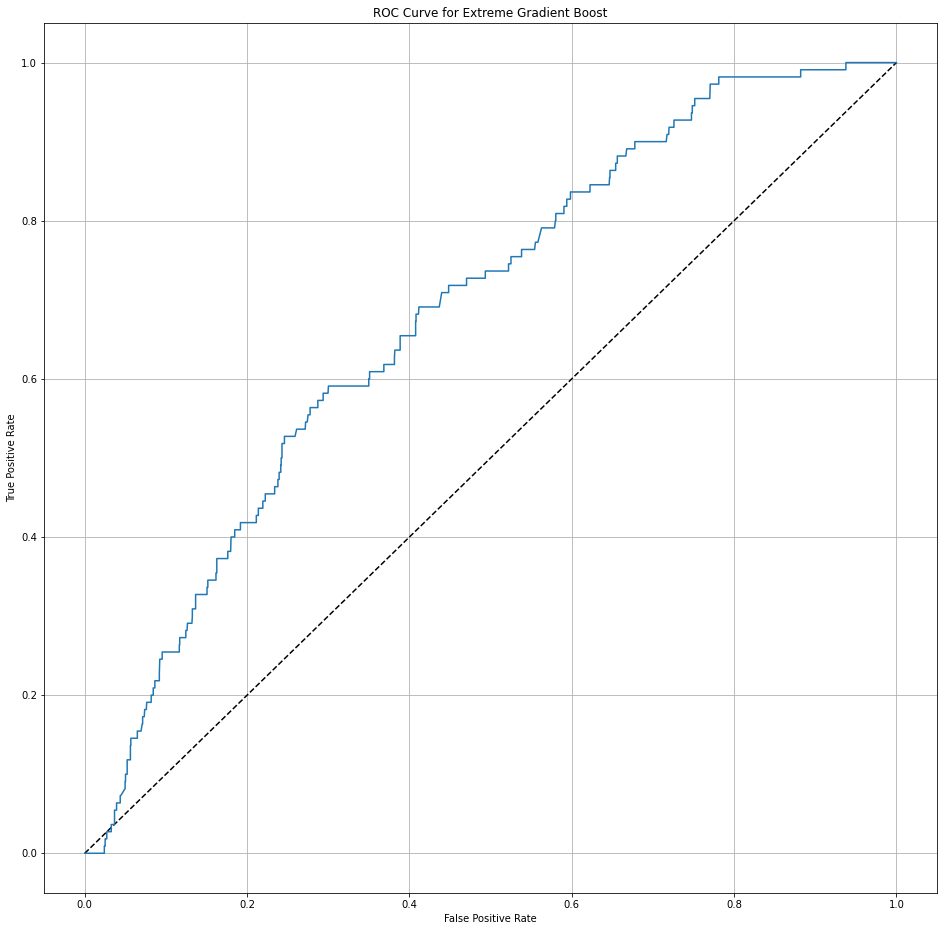

In [12]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.subplots(figsize = (16,16))
plt.plot([0,1], [0,1], 'k--')

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Extreme Gradient Boost')
plt.grid(True)
plt.show()

#### Hyperparameter Tuning Using GridSearchCV

# 2. Random Forest Classifier

#### Fit Random Forest Classifier

In [13]:
rf_clf = RandomForestClassifier(n_estimators=300, random_state = 42,n_jobs=-1)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
y_pred_training = rf_clf.predict(X_train)
y_pred_probs = rf_clf.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_pred)

0.6819459656809055

In [14]:
print("Classification Report for Training Data")
print(classification_report(y_train, y_pred_training))

Classification Report for Training Data
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       441
           1       0.99      0.91      0.95       441

    accuracy                           0.95       882
   macro avg       0.95      0.95      0.95       882
weighted avg       0.95      0.95      0.95       882



In [15]:
print("Classification Report for Test Data")
print(classification_report(y_test, y_pred))

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.97      0.79      0.87      1992
           1       0.13      0.57      0.21       110

    accuracy                           0.78      2102
   macro avg       0.55      0.68      0.54      2102
weighted avg       0.93      0.78      0.84      2102



#### Create Confusion Matrix Plots

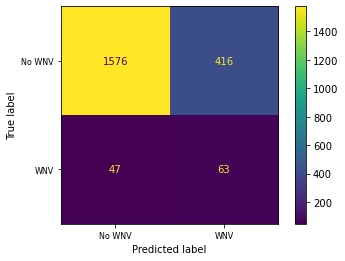

In [16]:
cm = confusion_matrix(y_test, y_pred, labels = rf_clf.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['No WNV', 'WNV'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['No WNV', 'WNV'], fontsize = 8)
ax.set_yticklabels(labels = ['No WNV', 'WNV'], fontsize = 8)
display_cm.plot(ax = ax)

#### Plot ROC

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.


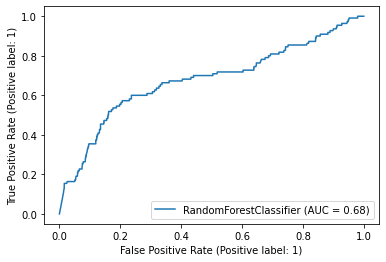

In [17]:
plot_roc_curve(rf_clf, X_test, y_test)

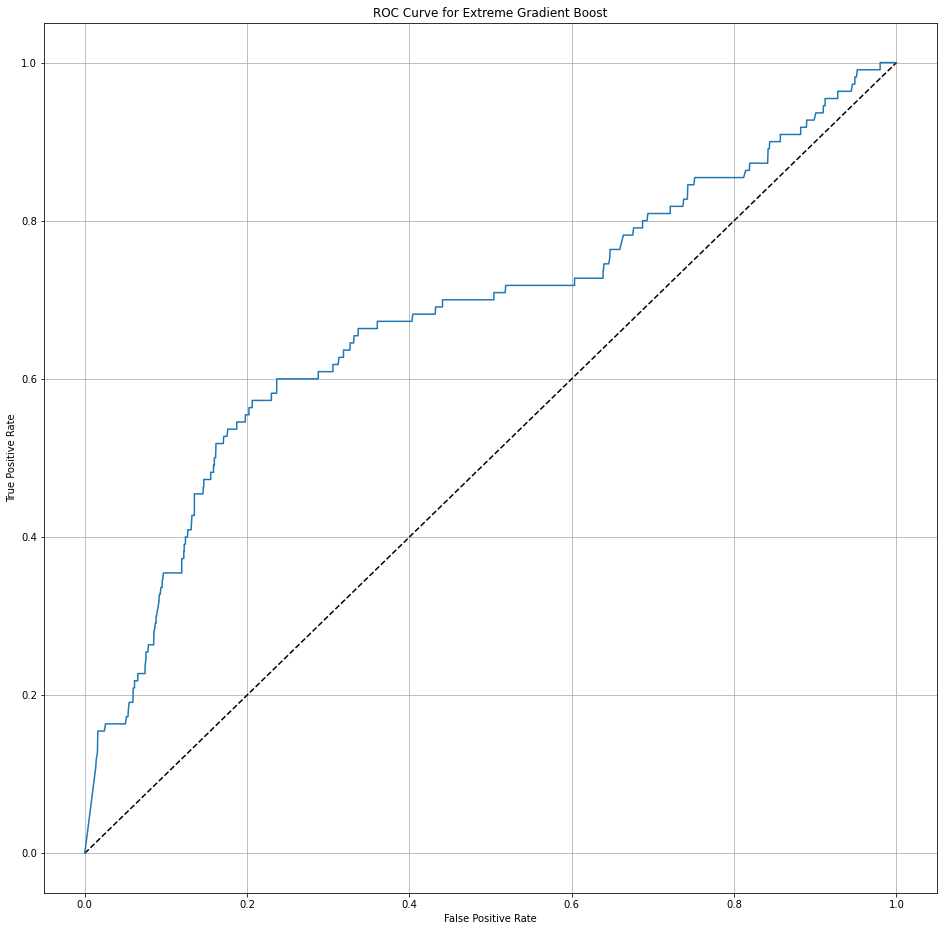

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.subplots(figsize = (16,16))
plt.plot([0,1], [0,1], 'k--')

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Extreme Gradient Boost')
plt.grid(True)
plt.show()

#### Plot Feature Importances

30


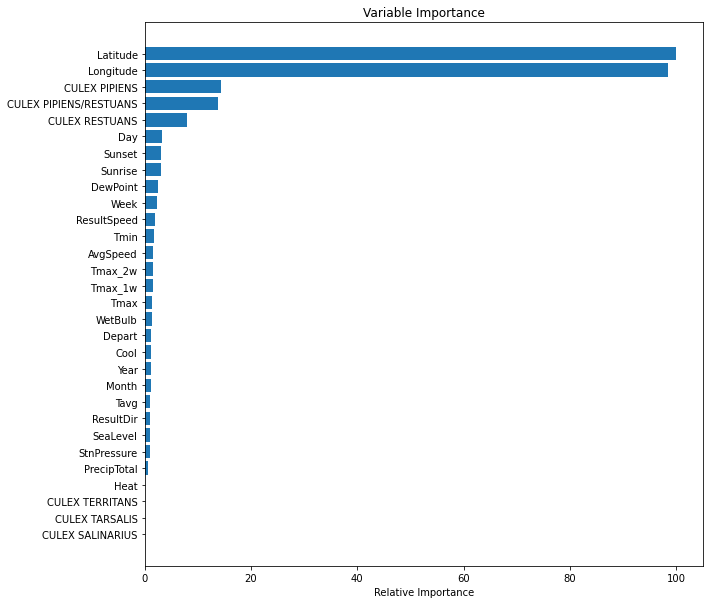

In [19]:
feature_importance = rf_clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Using SHAP

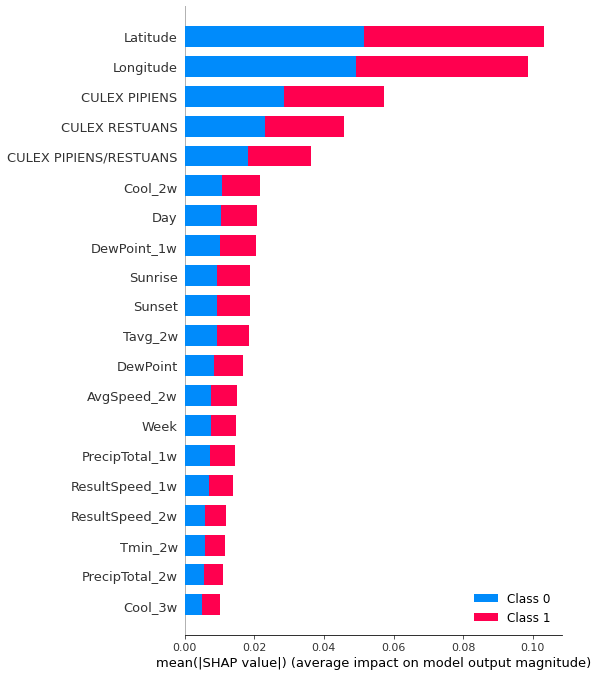

In [20]:
shap.initjs()

explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values,X_train, max_display=20)

#### Hyperparameter Tuning Using GridSearchCV

# 3. Extreme Gradient Boosting

#### Fit XGB Classifier

In [21]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
y_pred_training = xgb_clf.predict(X_train)
y_pred_probs = xgb_clf.predict_proba(X_test)[:,1]


roc_auc_score(y_test, y_pred)

0.6528249361080687

In [22]:
print("Classification Report for Training Data")
print(classification_report(y_train, y_pred_training))

Classification Report for Training Data
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       441
           1       1.00      0.90      0.95       441

    accuracy                           0.95       882
   macro avg       0.95      0.95      0.95       882
weighted avg       0.95      0.95      0.95       882



In [23]:
print("Classification Report for Test Data")
print(classification_report(y_test, y_pred))

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.97      0.65      0.78      1992
           1       0.09      0.65      0.16       110

    accuracy                           0.65      2102
   macro avg       0.53      0.65      0.47      2102
weighted avg       0.93      0.65      0.75      2102



#### Create Confusion Matrix Plots

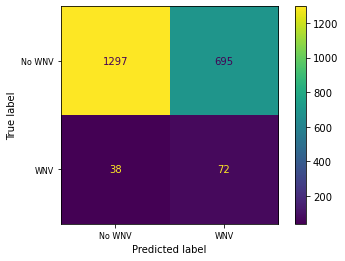

In [24]:
cm = confusion_matrix(y_test, y_pred, labels = xgb_clf.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['No WNV', 'WNV'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['No WNV', 'WNV'], fontsize = 8)
ax.set_yticklabels(labels = ['No WNV', 'WNV'], fontsize = 8)
display_cm.plot(ax = ax)

#### Plot ROC

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.


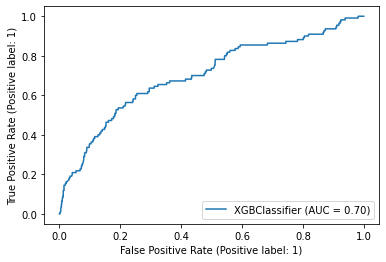

In [25]:
plot_roc_curve(xgb_clf, X_test, y_test)

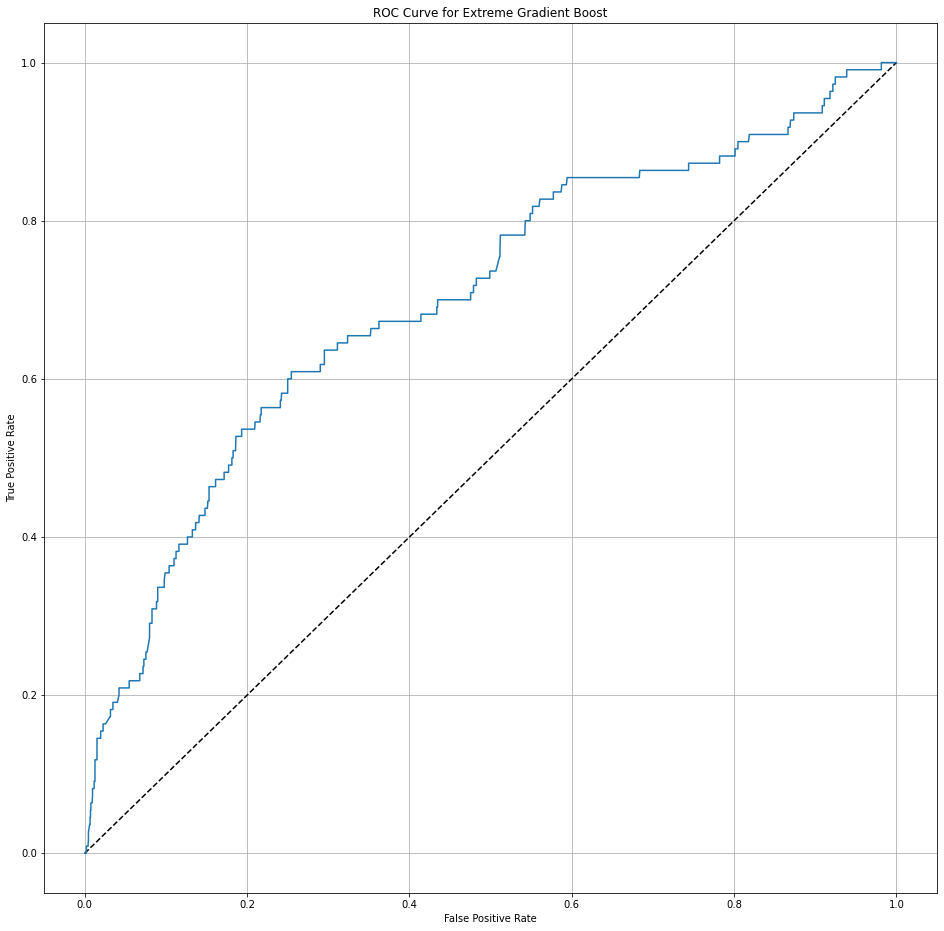

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.subplots(figsize = (16,16))
plt.plot([0,1], [0,1], 'k--')

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Extreme Gradient Boost')
plt.grid(True)
plt.show()

#### Plot Feature Importances

30


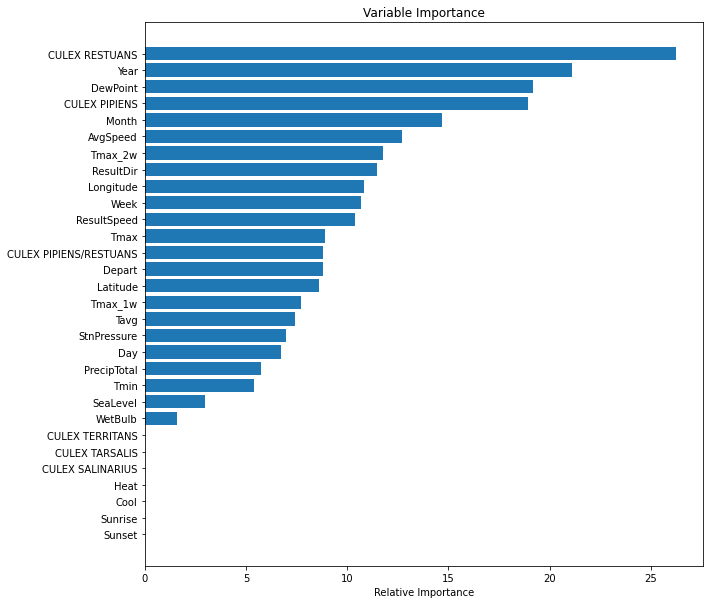

In [27]:
feature_importance = xgb_clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Using SHAP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


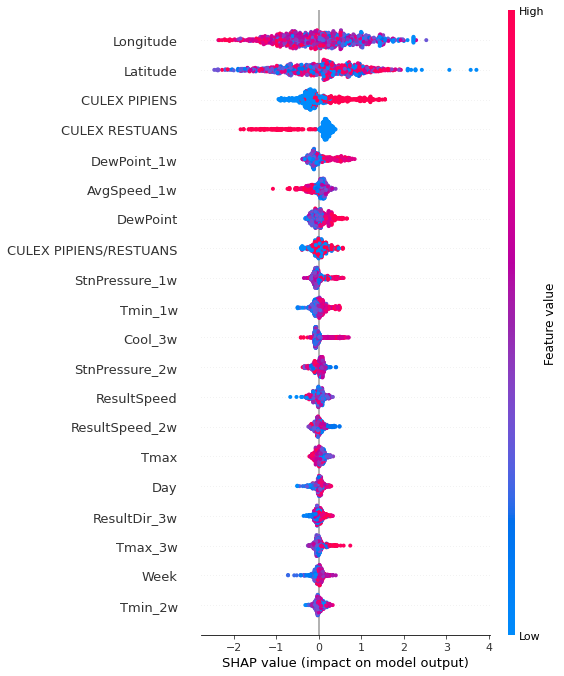

In [28]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values,X_train, max_display=20)

#### Hyperparameter Tuning Using GridSearchCV

### Notes:
### 1. Still have to figure out GridSearchCV - the amount of hyperparameters to tune and where to start is overwhelming.
### 2. My AUCROC score seems very low for all of my models and not sure I'm plotting them correctly.
### 3. Latitude and Longitude seem disproporionately important in my Random Forest Classifier.
### 4. SHAP feature importances don't seem to agree with SKlearns feature importances
